## 0. Import modules

In [32]:
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
from sympy import N
from IPython import display

from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

import torch
try:
    from snntorch.spikegen import rate, latency, delta
    import snntorch.spikeplot as splt
except ImportError:
    !pip install snntorch
    from snntorch.spikegen import rate, latency, delta
    import snntorch.spikeplot as splt

import h5py

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

try:
    from codecarbon import EmissionsTracker
except ImportError:
    !pip install codecarbon
    from codecarbon import EmissionsTracker

## 1. Environment setup

In [33]:
def setup_environment():
    """Setup paths and detect if running on Google Colab."""
    try:
        # Check if running on Google Colab
        from google.colab import drive

        drive.mount('/content/drive', force_remount=True)
        base_dir = '/content/TFM/SNN/'
        os.makedirs(f"{base_dir}CL", exist_ok=True)

        is_colab = True
    except ImportError:
        # Fallback for local environment
        base_dir = '/home/scosta/TFM/'
        is_colab = False

    # Change to the base directory
    os.chdir(base_dir)

    # Print the current working directory
    print(f"Current working directory: {os.getcwd()}")

    return is_colab, base_dir

# Detect environment and set up paths
is_colab, base_dir = setup_environment()

Current working directory: /home/scosta/TFM


## 2. Define auxiliary functions

In [34]:
def balance_steering_data(df, num_bins=15, samples_per_bin=200):
    # This function has been modified from:
    # Martínez, F.S. (2022). Conducción autónoma mediante redes convolucionales y clonación del comportamiento (Master's Project). Universitat Oberta de Catalunya.
    """
    Adjust a non-uniform steering angle distribution to make it more uniform.
    The aim is to reduce the tendency for driving straight by balancing the steering angles.

    Parameters:
        df (DataFrame): Input DataFrame containing 'steering' column.
        num_bins (int): Number of bins to group the steering data (odd number for central distribution).
        samples_per_bin (int): Maximum number of samples allowed per bin.

    Returns:
        DataFrame: A DataFrame with a more uniform distribution of steering angles.
    """

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Compute histogram and bin edges
    hist, bins = np.histogram(df["steering"], num_bins)
    center = (bins[:-1] + bins[1:]) * 0.5  # Calculate bin centers

    # Initialize list to track indices to remove
    remove_list = []

    # Iterate through each bin
    for j in range(num_bins):
        # Get indices of rows where steering values fall into the bin range
        bin_indices = df[(df["steering"] >= bins[j]) & (df["steering"] < bins[j + 1])].index.tolist()
        
        # Shuffle the indices to randomize
        bin_indices = shuffle(bin_indices)
        
        # Keep only the desired number of samples, remove the rest
        if len(bin_indices) > samples_per_bin:
            excess_indices = bin_indices[samples_per_bin:]  # Keep only samples_per_bin, drop the rest
            remove_list.extend(excess_indices)

    # Remove rows with indices in the remove_list
    df.drop(index=remove_list, inplace=True)
    df.reset_index(drop=True, inplace=True)  # Reset index after removal

    print(f"Removed: {len(remove_list)} samples")
    print(f"Remaining: {len(df)} samples")

    # Plot histogram of the remaining samples
    hist, _ = np.histogram(df["steering"], num_bins)
    df_bar = pd.DataFrame({"bins": center, "counts": hist})

    fig = px.bar(df_bar, x="bins", y="counts", text="counts", title="Remaining samples after balancing")
    fig.add_hline(y=samples_per_bin, line_color="green", line_dash="dash", annotation_text="Max samples per bin")
    fig.update_layout(bargap=0.1)
    fig.show()

    return df

# Define function to encode data as spikes and save to H5
def encode_and_save_to_h5(df, path_to_save, encoding="rate", num_steps=30, gain=1.0, tau=1.0,
                          threshold=0.5, padding=False, off_spike=False, split_ratio=0.7, track=None):
    # This function has been modified from:
    # Martínez, F.S. (in process). Eco-efficiency of SNNs in autonomous driving (PhD. Dissertation). Universitat Oberta de Catalunya.
    
    # Ensure the save path exists
    os.makedirs(path_to_save, exist_ok=True)

    # Generate file name based on encoding and parameters
    if encoding == "rate":
        h5_filename = f"encoded_dataset_rate_numsteps_{num_steps}_gain_{gain}.h5"
    elif encoding == "latency":
        h5_filename = f"encoded_dataset_latency_numsteps_{num_steps}_tau_{tau}.h5"
    else:
        raise ValueError("Unsupported encoding type. Choose from 'rate' or 'latency'.")

    # Combine path_to_save and generated filename
    h5_file_path = os.path.join(path_to_save, h5_filename)

    # Split into train and validation sets
    train_data, val_data = train_test_split(df, shuffle=True, test_size=(1 - split_ratio), random_state=42)
    train_data.reset_index(drop=True, inplace=True)
    val_data.reset_index(drop=True, inplace=True)

    # Determine dataset sizes
    num_train_samples = len(train_data)
    num_val_samples = len(val_data)
   
    # Define base transform (resize)
    base_transform = transforms.Resize((66, 200))

    # Define augmentation
    augment_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])

    # Open H5 file for writing
    with h5py.File(h5_file_path, 'w') as h5_file:
        # Create datasets
        train_img_dset = h5_file.create_dataset("train_images", shape=(num_train_samples, num_steps, 1, 66, 200), dtype='float32')
        train_label_dset = h5_file.create_dataset("train_labels", shape=(num_train_samples,), dtype='float32')
        val_img_dset = h5_file.create_dataset("val_images", shape=(num_val_samples, num_steps, 1, 66, 200), dtype='float32')
        val_label_dset = h5_file.create_dataset("val_labels", shape=(num_val_samples,), dtype='float32')

        # Function to encode a single image
        def encode_image(image):
            if encoding == "rate":
                return rate(image, num_steps=num_steps, gain=gain).numpy()
            elif encoding == "latency":
                return latency(image, num_steps=num_steps, tau=tau, normalize=True).numpy()
            else:
                raise ValueError(f"Invalid encoding type: '{encoding}'. Supported types are 'rate' and 'latency'.")

        # Encode and save each split
        for name, split_data in {'train': train_data, 'val': val_data}.items():
            for idx, row in tqdm(split_data.iterrows(), total=len(split_data)):
                img_path = row['image_path']  # Assuming 'center' column contains image paths
                steering_angle = row['steering']  # Assuming 'steering' column contains labels

                # Load and transform the image
                image = Image.open(img_path)
                image = base_transform(image)
                if name == 'train':
                    image = augment_transform(image)
                image = image.convert('L')  # Convert to grayscale
                image = transforms.ToTensor()(image)
                image = transforms.Normalize((0,), (1,))(image)

                # Encode image
                encoded_image = encode_image(image)

                # Save to H5
                if name == 'train':
                    train_img_dset[idx] = encoded_image
                    train_label_dset[idx] = steering_angle
                elif name == 'val':
                    val_img_dset[idx] = encoded_image
                    val_label_dset[idx] = steering_angle
    print(f"Encoded data saved to {h5_file_path}.")
    return h5_file_path

## 3. Data loading

In [35]:
# Define filepaths to driving logs
file_path_track1A = 'SNN/TrainImagesTFM_1_2/track1/driving_log.csv' # Path to the driving log for track 1
file_path_track1B = 'SNN/TrainImagesTFM_1_2/track1B/driving_log.csv' # Path to additional track 1 data
file_path_track2 = 'SNN/TrainImagesTFM_1_2/track2/driving_log.csv' # Path to the driving log for track 2

# Read the CSV file into a DataFrame
track1B_df = pd.read_csv(file_path_track1B, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])
track1A_df = pd.read_csv(file_path_track1A, header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])
track2_df = pd.read_csv(file_path_track2, header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])
track1_df = pd.concat([track1A_df, track1B_df] , ignore_index=True)
dfs = [track1_df, track2_df]

## 4. Steering angle correction for side cameras

In [36]:
camera_corrected_dfs = []
for i, frame in enumerate(dfs):
    if i == 0:
        frame = frame.drop(index=range(5150, 5330))
    #Melt the DataFrame so 'center', 'left', and 'right' are in a single column 
    frame = frame.melt(
        id_vars=['steering', 'throttle', 'brake', 'speed'],  # Columns to keep
        value_vars=['center', 'left', 'right'],  # Columns to unpivot
        var_name='position',  # New column to indicate 'center', 'left', or 'right'
        value_name='image_path'  # New column for the file paths
    )  
    #Increment steering by 0.2 where position is 'left'
    frame.loc[frame['position'] == 'left', 'steering'] += 0.2

    # Decrement steering by 0.2 where position is 'right'
    frame.loc[frame['position'] == 'right', 'steering'] -= 0.2
    frame =frame[(frame['steering'] <= 1) & (frame['steering'] >= -1)]
    camera_corrected_dfs.append(frame)

## 5. Balance distribution

Removed: 39760 samples
Remaining: 7041 samples


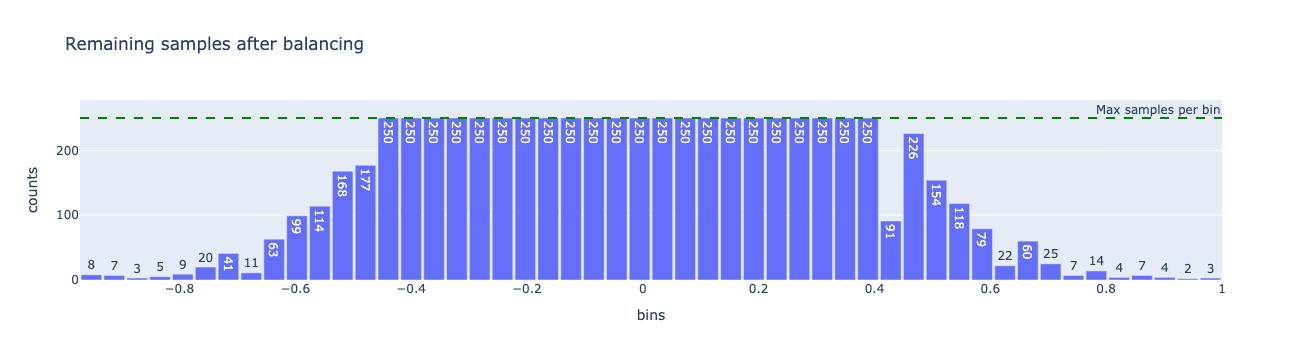

Removed: 8155 samples
Remaining: 7032 samples


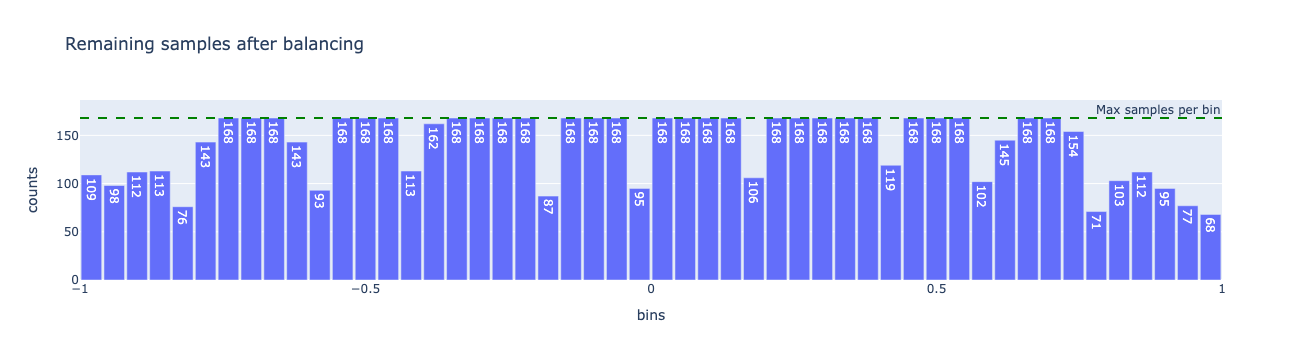

In [37]:
corrected_dfs = [df.copy() for df in camera_corrected_dfs]
# Balance steering data distribution to avoid overrepresentation of central angles
for i, frame in enumerate(corrected_dfs):
    if i == 0:
        balance_steering_data(frame, num_bins=50, samples_per_bin = 250)
    else:
        balance_steering_data(frame, num_bins=50, samples_per_bin = 168)

## 6. Data encoding

In [10]:
# Set environmental variables
tracks = {'track1': corrected_dfs[0], 'track2': corrected_dfs[1]}

# Define encoding options
encode = 'rate'
num_steps = 25
gain = 0.5

# Paths to your data and output H5 file
data_dir='SNN/TrainImagesTFM_1_2/'
out_data_dir='SNN/data/encoded/'
out_data_dir='SNN/data/encoded/test' # removeme

# seed for reproducibility
SEED = 42

In [11]:
# Seed the process
random.seed(SEED) # Python random module
np.random.seed(SEED) # NumPy
torch.manual_seed(SEED)  # PyTorch

h5_files = []
for track, df in tracks.items():
    # paths
    path_to_save = os.path.join(out_data_dir, track, encode, 'Encoded_Datasets')  # Directory where H5 files will be saved
    
    # Tracker config
    path_to_tracker_out = os.path.join(out_data_dir, track, encode, 'Emissions')  # Directory where tracker files will be saved
    os.makedirs(path_to_tracker_out, exist_ok=True)
    
    tracker = EmissionsTracker(
        project_name="Experiment_" + str(num_steps)+ '_' + str(gain),
        output_dir = path_to_tracker_out,
        output_file= 'emissions_' + str(num_steps)+ '_' + str(gain) + '.csv',
        log_level="warning")        
    tracker.start()
    
    h5_file = encode_and_save_to_h5(df, path_to_save, encoding=encode,
                          num_steps=num_steps,
                          gain=gain,
                          tau=None,
                          threshold=None)
    h5_files.append(h5_file)
    
    emissions: float = tracker.stop()

[codecarbon WARNING @ 19:30:43] No CPU tracking mode found. Falling back on CPU constant mode.
100%|██████████| 1989/1989 [00:17<00:00, 115.23it/s]
/home/scosta/miniconda3/envs/tfmenv/lib/python3.12/site-packages/codecarbon/output.py:123: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[codecarbon WARNING @ 19:31:53] No CPU tracking mode found. Falling back on CPU constant mode.


Encoded data saved to SNN/data/encoded/track1/rate/Encoded_Datasets/encoded_dataset_rate_numsteps_25_gain_0.5.h5.


100%|██████████| 2113/2113 [00:57<00:00, 36.52it/s] 


Encoded data saved to SNN/data/encoded/track2/rate/Encoded_Datasets/encoded_dataset_rate_numsteps_25_gain_0.5.h5.


/home/scosta/miniconda3/envs/tfmenv/lib/python3.12/site-packages/codecarbon/output.py:123: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



## 7. Figure generation

Figures saved as circuit_1.png and circuit_1.svg


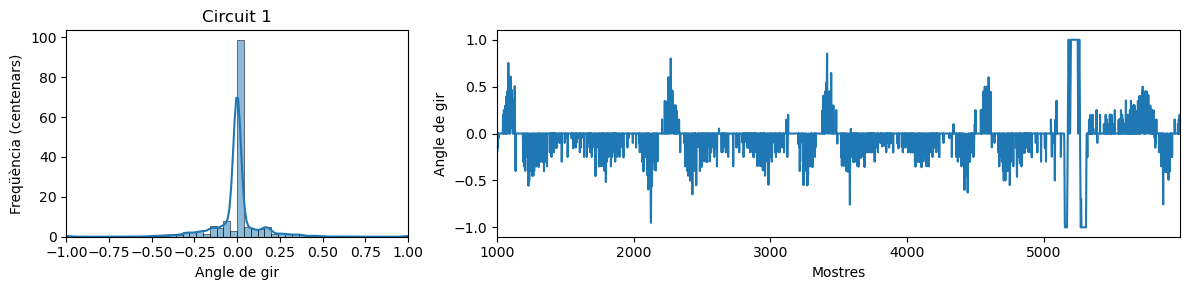

Figures saved as circuit_2.png and circuit_2.svg


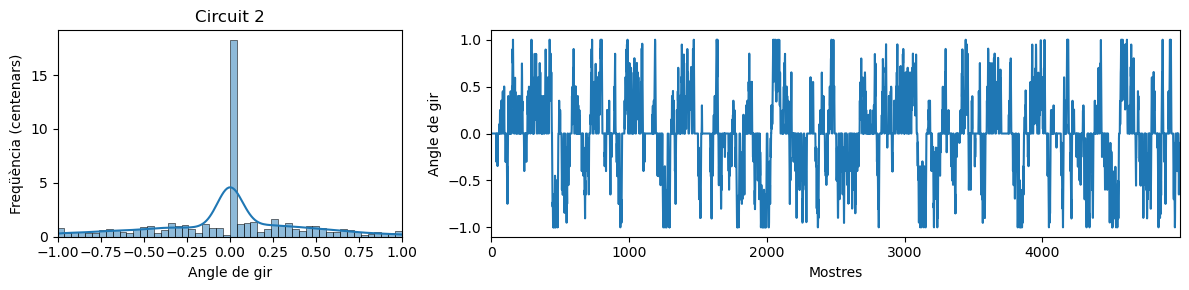

In [60]:
# Show distribution before any correction
plt.rcParams['figure.figsize'] = [12, 3]

for i, frame in enumerate(dfs):
    # Create a figure with two subplots of different widths
    fig = plt.figure(figsize=(12, 3))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])  # 1/3 width for histogram, 2/3 for plot

    # Histogram
    ax1 = fig.add_subplot(gs[0])
    sns.histplot(frame['steering'], bins=50, kde=True, ax=ax1)
    ax1.set_title(f'Circuit {i + 1}')
    ax1.set_xlabel('Angle de gir')
    ax1.set_ylabel('Freqüència (centenars)')
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x / 100)}'))
    ax1.set_xlim(frame['steering'].min(), frame['steering'].max())

    # Line plot
    if i == 0: 
        x_min = 1000
        x_max = 6000
    else:
        x_min = 0
        x_max = 5000

    ax2 = fig.add_subplot(gs[1])
    ax2.plot(frame[x_min:x_max].index, frame['steering'][x_min:x_max], label='Steering Angle', color='tab:blue')
    ax2.set_xlabel('Mostres')
    ax2.set_ylabel('Angle de gir')
    ax2.set_xlim(frame[x_min:x_max].index.min(), frame[x_min:x_max].index.max())
    plt.tight_layout()

    # Save the figure as PNG and SVG files
    png_filename = f'circuit_{i + 1}.png'
    svg_filename = f'circuit_{i + 1}.svg'
    plt.savefig(png_filename, dpi=300, bbox_inches='tight')
    plt.savefig(svg_filename, bbox_inches='tight')
    print(f"Figures saved as {png_filename} and {svg_filename}")

    # Show the plot
    plt.show()


Figures saved as circuits_histograms.png and circuits_histograms.svg


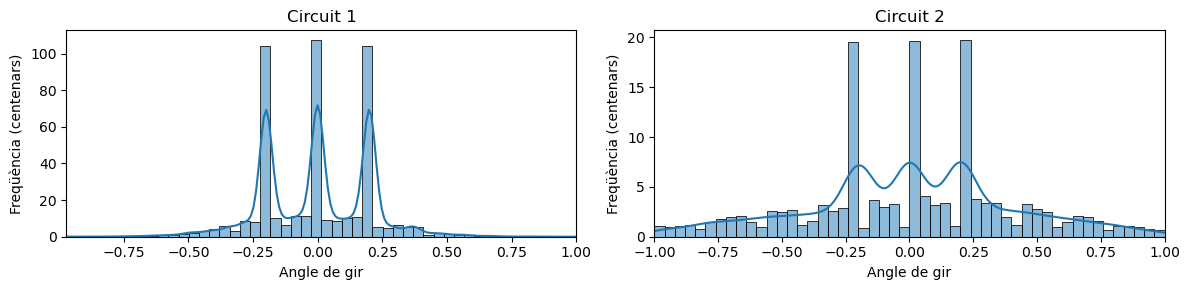

In [24]:
# Show distribution after steering angle correction for side cameras
plt.rcParams['figure.figsize'] = [12, 3]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Equal width for both histograms

for i, frame in enumerate(camera_corrected_dfs):
    # Histogram
    ax = fig.add_subplot(gs[i])
    sns.histplot(frame['steering'], bins=50, kde=True, ax=ax)
    ax.set_title(f'Circuit {i + 1}')
    ax.set_xlabel('Angle de gir')
    ax.set_ylabel('Freqüència (centenars)')

    # Update y-axis units to hundreds
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x / 100)}'))
    
    # Tighten x-axis limits for histogram to reduce empty space
    ax.set_xlim(frame['steering'].min(), frame['steering'].max())

# Adjust layout
plt.tight_layout()

# Save the figure as PNG and SVG files
png_filename = 'circuits_histograms.png'
svg_filename = 'circuits_histograms.svg'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.savefig(svg_filename, bbox_inches='tight')
print(f"Figures saved as {png_filename} and {svg_filename}")

# Show the plot
plt.show()

Figures saved as circuits_histograms_proc.png and circuits_histograms_proc.svg


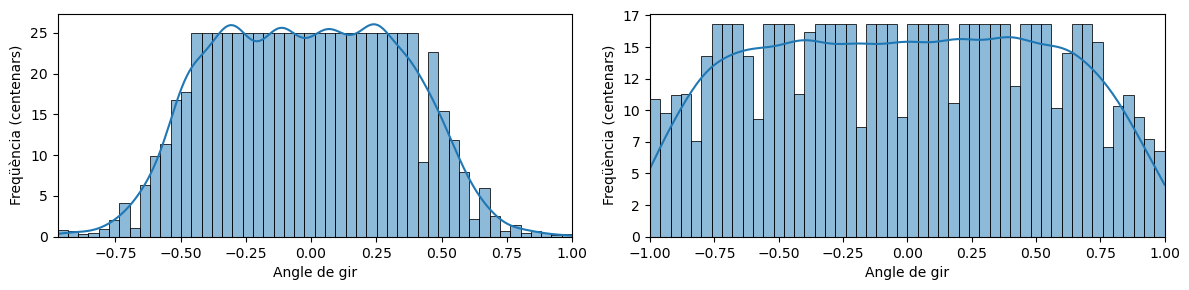

In [25]:
# Show final distribution
plt.rcParams['figure.figsize'] = [12, 3]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])  # Equal width for both histograms

for i, frame in enumerate(corrected_dfs):
    # Histogram
    ax = fig.add_subplot(gs[i])
    sns.histplot(frame['steering'], bins=50, kde=True, ax=ax)
    # ax.set_title(f'Circuit {i + 1}')
    ax.set_xlabel('Angle de gir')
    ax.set_ylabel('Freqüència (centenars)')

    # Update y-axis units to hundreds
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x / 10)}'))
    
    # Tighten x-axis limits for histogram to reduce empty space
    ax.set_xlim(frame['steering'].min(), frame['steering'].max())

# Adjust layout
plt.tight_layout()

# Save the figure as PNG and SVG files
png_filename = 'circuits_histograms_proc.png'
svg_filename = 'circuits_histograms_proc.svg'
plt.savefig(png_filename, dpi=300, bbox_inches='tight')
plt.savefig(svg_filename, bbox_inches='tight')
print(f"Figures saved as {png_filename} and {svg_filename}")

# Show the plot
plt.show()

In [41]:
## Display encoded data
random.seed(42) # Ensure reproducibility
h5_file_path = 'SNN/data/encoded/track1/rate/Encoded_Datasets/encoded_dataset_rate_numsteps_25_gain_0.5.h5' # Dataset file
num_images = 3 # number of  images to  display

with h5py.File(h5_file_path, 'r') as f:
    # Check available datasets
    print("Datasets in file:", list(f.keys()))

    # Access training images and labels
    train_images = f['train_images']
    train_labels = f['train_labels']
    print("Train images shape:", train_images.shape)
    print("Train labels shape:", train_labels.shape)

    # Access validation images and labels
    val_images = f['val_images']
    val_labels = f['val_labels']
    print("Validation images shape:", val_images.shape)
    print("Validation labels shape:", val_labels.shape)

    # Randomly select `num_images` indices from the entire dataset
    selected_indices = random.sample(range(len(train_images)), num_images)
    
    # Display the specified number of images and their steering angles
    for i, idx in enumerate(selected_indices):
        img = train_images[idx]
        angle = train_labels[idx]
        print(f"Steering angle: {angle} and image shape: {img.shape}")

        img_tensor = torch.from_numpy(img).squeeze()  # Remove the single-channel dimension if present
        fig, ax = plt.subplots()
        print(f"img_tensor shape: {img_tensor.shape}")
        anim = splt.animator(img_tensor, fig, ax)
        display.display(display.HTML(anim.to_html5_video()))
        anim.save(f"/home/scosta/TFM/SNN/data/encoded/Latency/Animations/spike_image_{i}.mp4")
        plt.close()

Datasets in file: ['train_images', 'train_labels', 'val_images', 'val_labels']
Train images shape: (4928, 25, 1, 66, 200)
Train labels shape: (4928,)
Validation images shape: (2113, 25, 1, 66, 200)
Validation labels shape: (2113,)
Steering angle: -0.15709669888019562 and image shape: (25, 1, 66, 200)
img_tensor shape: torch.Size([25, 66, 200])


Steering angle: -0.5478485226631165 and image shape: (25, 1, 66, 200)
img_tensor shape: torch.Size([25, 66, 200])


Steering angle: -0.20000000298023224 and image shape: (25, 1, 66, 200)
img_tensor shape: torch.Size([25, 66, 200])


'/home/scosta/TFM'